In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from numba import njit
from tqdm.notebook import tqdm
import talib

import os, sys

sys.path.append(os.path.abspath(os.path.join('../')))
from generative_models import *
from fast_dm_simulator import *

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

In [3]:
# gpu setting and checking
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
# print(tf.config.list_physical_devices('GPU'))

In [4]:
%load_ext autoreload
%autoreload 2
np.set_printoptions(suppress=True)

# Amortizer

## Network architecture

In [5]:
class HeteroscedasticNetwork(tf.keras.Model):
    
    def __init__(self, n_params_d, n_params_s):
        super(HeteroscedasticNetwork, self).__init__()
        
        self.preprocessor = Sequential([
            GRU(64, return_sequences=True),
            LSTM(128, return_sequences=True),
            Dense(128, activation='selu', kernel_initializer='lecun_normal'),
        ])
        
        self.dynamic_predictor = Sequential([
            Dense(64, activation='selu', kernel_initializer='lecun_normal'),
            tf.keras.layers.Dense(tfpl.MultivariateNormalTriL.params_size(n_params_d)),
            tfpl.MultivariateNormalTriL(n_params_d)
        ])

        self.static_predictor = Sequential([
            LSTM(n_params_s),
            Dense(tfpl.MultivariateNormalTriL.params_size(n_params_s)),
            tfpl.MultivariateNormalTriL(n_params_s)
        ])
        
    def call(self, x):
        """
        Forward pass through the model.
        """
        
        # Obtain representation
        rep = self.preprocessor(x)
        
        # Predict dynamic
        preds_dyn = self.dynamic_predictor(rep)

        # predict static
        preds_stat = self.static_predictor(rep)

        return preds_dyn, preds_stat

class StaticHeteroscedasticNetwork(tf.keras.Model):
    
    def __init__(self, n_params_d):
        super(HeteroscedasticNetwork, self).__init__()
        
        self.preprocessor = Sequential([
            GRU(64, return_sequences=True),
            LSTM(128, return_sequences=True),
            Dense(128, activation='selu', kernel_initializer='lecun_normal'),
        ])
        
        self.dynamic_predictor = Sequential([
            Dense(64, activation='selu', kernel_initializer='lecun_normal'),
            tf.keras.layers.Dense(tfpl.MultivariateNormalTriL.params_size(n_params_d)),
            tfpl.MultivariateNormalTriL(n_params_d)
        ])

        
    def call(self, x):
        """
        Forward pass through the model.
        """
        # Obtain representation
        rep = self.preprocessor(x)
        
        # Predict dynamic
        preds_dyn = self.dynamic_predictor(rep)

        return preds_dyn

## Loss

In [5]:
def nll(y_true, y_pred):
    return tf.reduce_mean(-y_pred.log_prob(y_true))

## Epoch helper

In [6]:
def epoch_trainer(network, optimizer, batch_size, n_obs, steps_per_epoch, p_bar):
    losses = []
    for step in range(1, steps_per_epoch+1):
        with tf.GradientTape() as tape:
            # Simulate from model
            prior_draws = dynamic_prior(batch_size)
            context = context_gen(batch_size, n_obs)
            sim_data, theta_d, theta_s = dynamic_batch_simulator(prior_draws, context)

            # predict
            net_in = tf.concat((sim_data[:, :, :1], to_categorical(sim_data[:, :, 1:])), axis=-1)
            pred_theta_d, pred_theta_s = network(net_in)

            # loss
            loss_d = nll(theta_d, pred_theta_d)
            loss_s = nll(theta_s, pred_theta_s)
            total_loss = loss_d + loss_s

        g = tape.gradient(total_loss, network.trainable_variables)
        optimizer.apply_gradients(zip(g, network.trainable_variables))
        losses.append(total_loss.numpy())

        # Update progress bar
        p_bar.set_postfix_str("Ep: {},Step {},Loss D: {:.3f} Running Loss: {:.3f}"
                              .format(ep, step, loss_d.numpy(), np.mean(losses)))
        p_bar.update(1)

def static_epoch_trainer(network, optimizer, batch_size, n_obs, steps_per_epoch, p_bar):
    
    losses = []
    for step in range(1, steps_per_epoch+1):
        with tf.GradientTape() as tape:
        
            # Simulate from model
            prior_draws = dynamic_prior(batch_size)
            context = context_gen(batch_size, n_obs)
            sim_data, theta_d = static_batch_simulator(prior_draws, context)

            net_in = tf.concat((sim_data[:, :, :1], to_categorical(sim_data[:, :, 1:])), axis=-1)
            pred_theta_d = network(net_in)

            # Loss 
            loss_d = nll(theta_d, pred_theta_d)
            
            total_loss = loss_d
        g = tape.gradient(total_loss, network.trainable_variables)
        optimizer.apply_gradients(zip(g, network.trainable_variables))
        losses.append(total_loss.numpy())

        # Update progress bar
        p_bar.set_postfix_str("Ep: {},Step {},Loss D: {:.3f} Running Loss: {:.3f}"
                              .format(ep, step, loss_d.numpy(), np.mean(losses)))
        p_bar.update(1)


# Training

In [6]:
N_OBS = 3200
BATCH_SIZE = 8
STEPS_PER_EPOCH = 1000
epochs = [50, 25, 25]
learning_rates = [0.0001, 0.00005, 0.00001]

## Dynamic

In [7]:
# initialize net
network = HeteroscedasticNetwork(6, 6)

In [ ]:
for i in range(len(epochs)):
    # set learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rates[i])
    
    # train epochs
    for ep in range(1, epochs[i]+1):
        with tqdm(total=STEPS_PER_EPOCH, desc='Training epoch {}'.format(ep)) as p_bar:
            epoch_trainer(network, optimizer, BATCH_SIZE, N_OBS, STEPS_PER_EPOCH, p_bar)
    
    #save weights
    network.save_weights('checkpoints/varying_hyperparams_3200')

## Static

In [ ]:
# initialize net
network = StaticHeteroscedasticNetwork(6)

In [ ]:
for i in range(len(epochs)):
    # set learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rates[i])
    
    # train epochs
    for ep in range(1, epochs[i]+1):
        with tqdm(total=STEPS_PER_EPOCH, desc='Training epoch {}'.format(ep)) as p_bar:
            static_epoch_trainer(network, optimizer, BATCH_SIZE, N_OBS, STEPS_PER_EPOCH, p_bar)
    
    #save weights
    network.save_weights('checkpoints/static_ddm_3200')

# Model fitting

In [8]:
# initialize net
network = HeteroscedasticNetwork(6, 6)
network.load_weights('checkpoints/varying_hyperparams_3200')

In [9]:
# read data
data = pd.read_csv('../../data/data_lexical_decision.csv', sep=',', header=0)

In [10]:
# subset data
which = 5
person_data = data[data.id == which]
person_data.shape

(3200, 13)

In [11]:
# prepare data for fitting
# negative rts for error responses
person_data.rt[person_data.acc == 0] = -person_data.rt[person_data.acc == 0]
rt = np.array([person_data.rt])[:, :, np.newaxis]
stim_type = np.array([person_data.stim_type])[:, :, np.newaxis] - 1 
context = to_categorical(stim_type)
x_nn = tf.concat((rt, context), axis=-1)
x_nn.shape

/var/folders/cd/lsff0c7s4fn3mb649wt67m200000gn/T/ipykernel_1439/2724316959.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  person_data.rt[person_data.acc == 0] = -person_data.rt[person_data.acc == 0]
/opt/anaconda3/envs/cognitiveModeling/lib/python3.9/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


TensorShape([1, 3200, 5])

In [12]:
# amortized inference
post_d, post_s = network(x_nn)

2022-04-05 12:40:55.134249: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


# Evaluation

In [515]:
# set font type
import matplotlib
matplotlib.rcParams['font.serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "serif"

In [516]:
#  Returns tuple of handles, labels for axis ax, after reordering them to conform to the label order `order`, and if unique is True, after removing entries with duplicate labels.
def reorderLegend(f=None,order=None,unique=False):
    if f is None: f=plt.gca()
    handles, labels = f.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0])) # sort both labels and handles by labels
    if order is not None: # Sort according to a given list (not necessarily complete)
        keys=dict(zip(order,range(len(order))))
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t,keys=keys: keys.get(t[0],np.inf)))
    if unique:  labels, handles= zip(*unique_everseen(zip(labels,handles), key = labels)) # Keep only the first of each handle
    f.legend(handles, labels,
              fontsize=16, loc='center', 
              bbox_to_anchor=(1.9, -0.4),fancybox=False, shadow=False, ncol=4)
    return(handles, labels)


def unique_everseen(seq, key=None):
    seen = set()
    seen_add = seen.add
    return [x for x,k in zip(seq,key) if not (k in seen or seen_add(k))]

In [517]:
def plot_dynamic_posteriors(dynamic_posterior, fast_dm_params, par_labels, par_names, 
                            ground_truths=None, color_pred='#852626'):
    """
    Inspects the dynamic posterior given a single data set. Assumes six dynamic paramters.
    """
    
    assert len(dynamic_posterior.shape) == 3, "Dynamic posterior should be 3-dimensional!" 
    assert ground_truths is None or len(ground_truths.shape) == 2,'Ground truths should be 2-dimensional!'
    assert dynamic_posterior.shape[0] == 1, "Function assumes dynamics posterior for a single data set!" 
        
    means = dynamic_posterior.mean()[0]
    std = dynamic_posterior.stddev()[0]
    
    sigma_factors = [1]
    alphas = [0.6]
    serif_font = "Computer Modern Roman"
    serif_font = "Palatino"

    time = np.arange(x_nn.shape[1])
    f, axarr = plt.subplots(2, 3, figsize=(18, 8))
    counter = 0
    for i, ax in enumerate(axarr.flat):
        
        ax.plot(time, means[:, i], color=color_pred, label='Posterior mean')
        for sigma_factor, alpha in zip(sigma_factors, alphas):
            ci_upper = means[:, i] + sigma_factor * std[:, i]
            ci_lower = means[:, i] - sigma_factor * std[:, i]
            ax.fill_between(time, ci_upper, ci_lower, color=color_pred, alpha=alpha, linewidth=0, label='Posterior sd')
        if ground_truths is not None:
            ax.plot(time, ground_truths[:, i], color='black', linestyle='dashed', label='True Dynamic', lw=2)
        sns.despine(ax=ax)
        ax.set_xlabel('Time (t)', fontsize=18)
        ax.set_ylabel('Parameter value ({})'.format(par_names[i]), fontsize=18)
        ax.set_title(par_labels[i] + ' ({})'.format(par_names[i]), fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.grid(False)

        # vertical bars
        for idx in np.arange(799, 2400, 800):
            if idx == 799:
                ax.axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.5)
            else:
                ax.axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.5)
        for idx in np.arange(99, 3100, 100):
            if idx == 99:
                ax.axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)
            else:
                ax.axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)

        

        # horizontal fast-dm params
        if i <= 3:
            ax.plot(time, np.repeat(params_fast_dm[i], x_nn.shape[1]), color='#598f70', alpha=1, label='Fast-dm estimate')
            ax.fill_between(time, params_fast_dm[i] - params_fast_dm[6], params_fast_dm[i] + params_fast_dm[6], color='#598f70', alpha=0.3, linewidth=0, label='Fast-dm variability')
        elif i == 4:
            ax.plot(time, np.repeat(params_fast_dm[i], x_nn.shape[1]), color='#598f70', alpha=1, label='Fast-dm estimate')
        else:
            ax.plot(time, np.repeat(params_fast_dm[i], x_nn.shape[1]), color='#598f70', alpha=1, label='Fast-dm estimate')
            ax.fill_between(time, params_fast_dm[i] - params_fast_dm[7]/2, params_fast_dm[i] + params_fast_dm[7]/2, color='#598f70', alpha=0.3, linewidth=0, label='Fast-dm variability')

        # Shrink current axis's height by 10% on the bottom
        # box = ax.get_position()
        # ax.set_position([box.x0, box.y0 + box.height * 0.1,
        #                 box.width, box.height * 0.9])

        f.subplots_adjust(hspace=0.5)
        if i == 0:
            f.legend(fontsize=16, loc='center', 
                     bbox_to_anchor=(0.5, -0.05),fancybox=False, shadow=False, ncol=4)

    f.tight_layout()
    f.savefig("plots/param_dynamic.png", dpi=300, bbox_inches="tight")

## Parameter dynamics: Empiric data

In [518]:
# read fast-dm parameter estimates
fast_dm_params = pd.read_csv('parameters_full_ddm_error_coding_cs.lst', encoding='iso-8859-1', header=0, delim_whitespace=True)
fast_dm_params['dataset'] = fast_dm_params['dataset'].str.extract('(\d+)').astype(int)
fast_dm_params = fast_dm_params[['dataset', 'v_1', 'v_2', 'v_3', 'v_4', 'a', 't0', 'sv', 'st0']]
fast_dm_params = fast_dm_params.sort_values('dataset')
fast_dm_params = fast_dm_params.reset_index(drop=True)

# subset fast_dm_params
params_fast_dm = fast_dm_params[fast_dm_params.dataset == which].values[0, 1:]
context = np.array(person_data['stim_type'] - 1)
pred_rt_fast_dm = fast_dm_simulate(params_fast_dm, context)

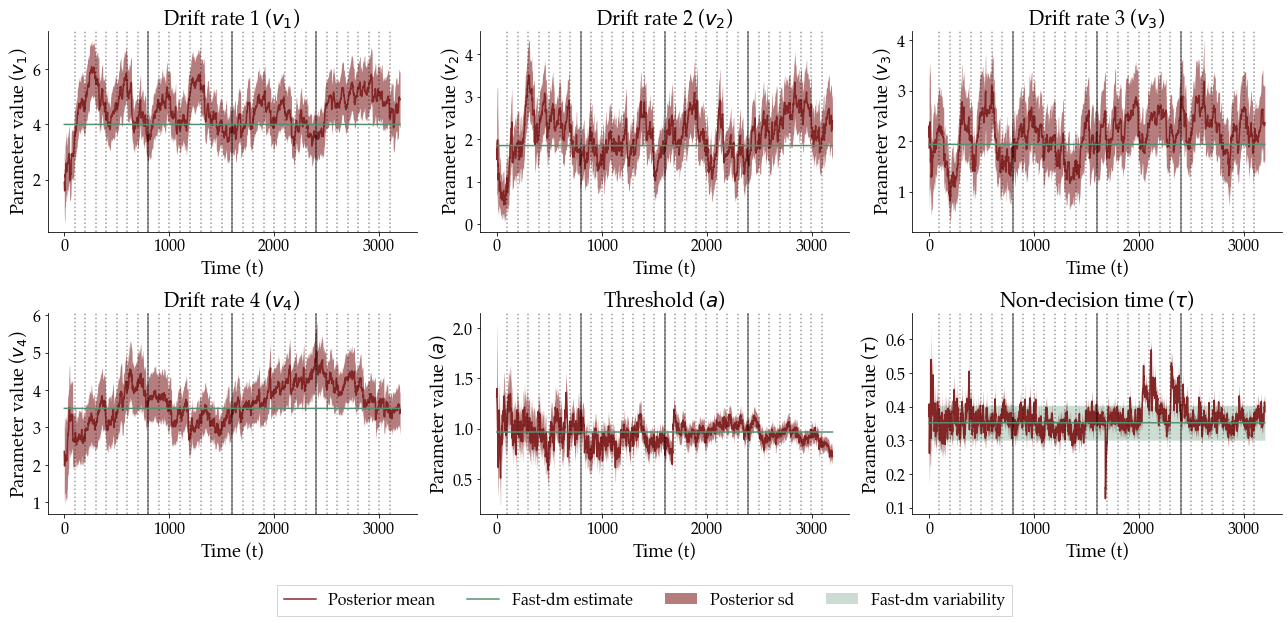

In [519]:
par_labels = ['Drift rate 1', 'Drift rate 2', 'Drift rate 3', 'Drift rate 4', 'Threshold', 'Non-decision time']
par_names = [r'$v_1$', r'$v_2$', r'$v_3$', r'$v_4$', r'$a$', r'$\tau$']
plot_dynamic_posteriors(post_d, params_fast_dm, par_labels, par_names)

## Posterior retrodictive checks

In [356]:
def pr_check(emp_data, post_d, n_sim, sma_period=5):
    # get experimental context
    context = emp_data.stim_type.values - 1
    # get empirical response times
    emp_rt = np.abs(emp_data.rt.values)
    sma_emp_rt = talib.SMA(emp_rt, timeperiod=sma_period)
    
    # sample from posterior
    theta_d = np.array([post_d.sample(n_sim)])[0, :, 0, :]

    n_obs = emp_rt.shape[0]
    pred_rt = np.zeros((n_sim, n_obs))
    sma_pred_rt = np.zeros((n_sim, n_obs))
    # iterate over number of simulations
    for sim in range(n_sim):
        # Iterate over number of trials
        rt = np.zeros(n_obs)
        for t in range(n_obs):
            # Run diffusion process
            rt[t] = diffusion_trial(theta_d[sim, t, context[t]], theta_d[sim, t, 4], theta_d[sim, t, 5])
        pred_rt[sim] = np.abs(rt)
        sma_pred_rt[sim] = talib.SMA(np.abs(rt), timeperiod=sma_period)

    return pred_rt, sma_pred_rt

In [504]:
%%time
pred_rt_dynamic, sma_pred_rt_dynamic = pr_check(person_data, post_d, 1000)

CPU times: user 5min 5s, sys: 2.35 s, total: 5min 7s
Wall time: 5min 7s


In [505]:
# summarize predicted response times
quantiles = np.quantile(sma_pred_rt_dynamic, [0.05, 0.95], axis=0)
median = np.median(sma_pred_rt_dynamic, axis=0)

In [506]:
# prepare emp rt data
emp_rt = np.abs(person_data.rt.values)
n_obs = emp_rt.shape[0]
sma_emp_rt = talib.SMA(emp_rt, timeperiod=5)

In [507]:
# read fast-dm parameter estimates
fast_dm_params = pd.read_csv('parameters_full_ddm_error_coding_cs.lst', encoding='iso-8859-1', header=0, delim_whitespace=True)
fast_dm_params['dataset'] = fast_dm_params['dataset'].str.extract('(\d+)').astype(int)
fast_dm_params = fast_dm_params[['dataset', 'v_1', 'v_2', 'v_3', 'v_4', 'a', 't0', 'sv', 'st0']]
fast_dm_params = fast_dm_params.sort_values('dataset')
fast_dm_params = fast_dm_params.reset_index(drop=True)

# subset fast_dm_params
params_fast_dm = fast_dm_params[fast_dm_params.dataset == which].values[0, 1:]
context = np.array(person_data['stim_type'] - 1)
pred_rt_fast_dm = fast_dm_simulate(params_fast_dm, context)

In [508]:
def reorderLegend2(ax=None,order=None,unique=False):
    if ax is None: ax=plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0])) # sort both labels and handles by labels
    if order is not None: # Sort according to a given list (not necessarily complete)
        keys=dict(zip(order,range(len(order))))
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t,keys=keys: keys.get(t[0],np.inf)))
    if unique:  labels, handles= zip(*unique_everseen(zip(labels,handles), key = labels)) # Keep only the first of each handle
    ax.legend(handles, labels,
              fontsize=16, loc='upper right')
    return(handles, labels)

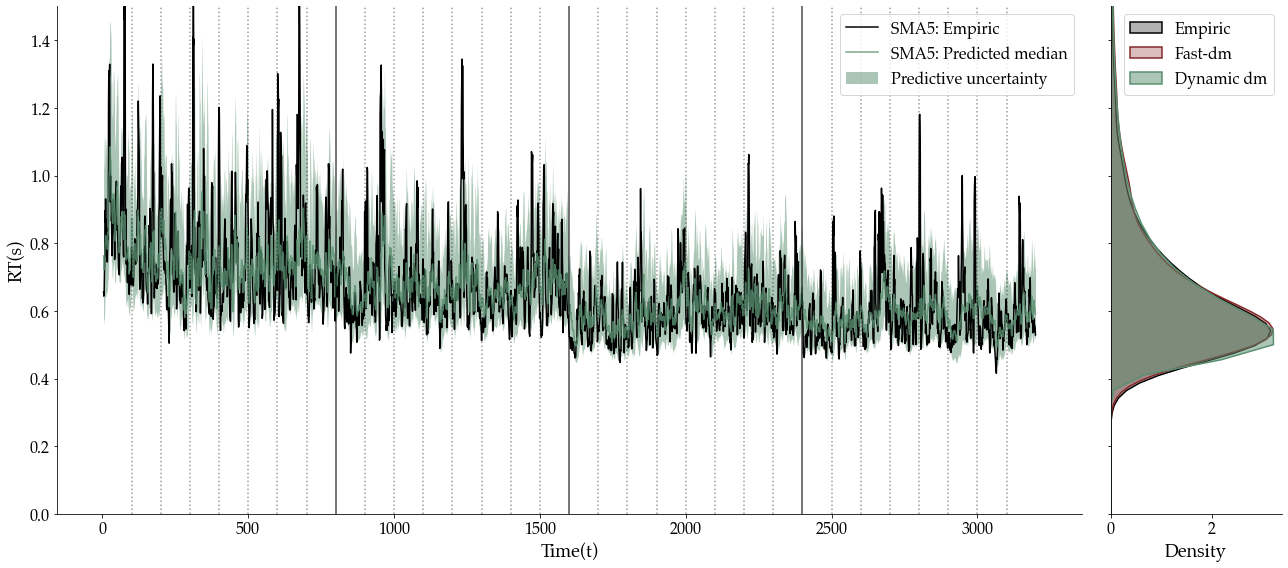

In [509]:
# initialize figure
f, ax = plt.subplots(1, 2, figsize=(18, 8),
                     gridspec_kw={'width_ratios': [6, 1]})

axrr = ax.flat

# plot empiric and predicted response times series
time = np.arange(n_obs) 
axrr[0].plot(time, sma_emp_rt, color='black', lw=1.5, label='SMA5: Empiric')
axrr[0].plot(time, median, color='#598f70', lw=1.5, label='SMA5: Predicted median', alpha=0.8)
axrr[0].fill_between(time, quantiles[0, :], quantiles[1, :], color='#598f70', linewidth=0, alpha=0.5, label='Predictive uncertainty')
for idx in np.argwhere(person_data.session.diff().values == 1):
    if idx == 800:
        axrr[0].axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.7)
    else:
        axrr[0].axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.7)
for idx in np.argwhere(person_data.block.diff().values == 1):
    if idx == 100:
        axrr[0].axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)
    else:
        axrr[0].axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)
sns.despine(ax=axrr[0])
axrr[0].grid(alpha=0.3)
axrr[0].set_ylabel('RT(s)', fontsize=18)
axrr[0].set_xlabel('Time(t)', fontsize=18)
axrr[0].tick_params(axis='both', which='major', labelsize=16)
reorderLegend2(axrr[0],['SMA5: Empiric', 'SMA5: Predicted median', 'Predictive uncertainty'])
axrr[0].grid(b=None)

# plot empiric and predicted response time dist
# axrr[1].get_shared_y_axes().join(axrr[1], axrr[0])
# axrr[0].sharey(axrr[1])
plt.setp(ax, ylim=(0, 1.5))
sns.kdeplot(y=np.abs(emp_rt), fill="black", color="black", linewidth=1.5, alpha=0.3, label="Empiric", ax=axrr[1])
sns.kdeplot(y=np.abs(pred_rt_fast_dm), fill= '#852626', color="#852626", alpha=0.3, linewidth=1.5, label="Fast-dm", ax=axrr[1])
sns.kdeplot(y=pred_rt_dynamic.flatten(),fill="#598f70", color="#598f70", linewidth=1.5, alpha=0.5, label="Dynamic dm", ax=axrr[1])

axrr[1].legend(fontsize=16)
axrr[1].set_xlabel('Density', fontsize=18)
axrr[1].tick_params(axis='both', which='major', labelsize=16)
axrr[1].set_yticklabels('')
sns.despine(ax=axrr[1])
plt.subplots_adjust(wspace = 0.05)
f.tight_layout()
f.savefig("plots/rt_time_series.png", dpi=300)



## Empiric vs. predicted rt distribution

In [ ]:
sns.kdeplot(pred_rt.flatten(), fill="navy", color="navy", label="Predicted")
sns.kdeplot(np.random.choice(np.abs(person_data.rt.values), size=pred_rt.flatten().size, replace=True), fill="maroon", color="maroon", label="Empiric")
sns.despine()
plt.legend()

## Parameter dynamics: Simulated data

In [ ]:
# dynamic simulation
n_obs = 800
n_test = 6
prior_draws = dynamic_prior(n_test)
context = context_gen(n_test, n_obs)
sim_data, theta_d, theta_s = dynamic_batch_simulator(prior_draws, context)
context = to_categorical(sim_data[:, :, 1])
rt = sim_data[:, :, 0, np.newaxis]
x_nn = tf.concat((rt, context), axis=-1)
x_nn.shape

In [ ]:
which = 4
post_d, post_s = network(x_nn[which:(which+1)])
ground_truths = theta_d[which]
par_labels = ['Drift rate 1', 'Drift rate 2', 'Drift rate 3', 'Drift rate 4', 'Threshold', 'Non-decision time']
par_names = [r'$v_1$', r'$v_2$', r'$v_3$', r'$v_3$', r'$a$', r'$\tau$']
plot_dynamic_posteriors(post_d, par_labels, par_names, ground_truths)

## Comparison with Fast-dm

In [15]:
# read parameter estimates
fast_dm_params = pd.read_csv('parameters_full_ddm_error_coding_cs.lst', encoding='iso-8859-1', header=0, delim_whitespace=True)
fast_dm_params['dataset'] = fast_dm_params['dataset'].str.extract('(\d+)').astype(int)
fast_dm_params = fast_dm_params[['dataset', 'v_1', 'v_2', 'v_3', 'v_4', 'a', 't0', 'sv', 'st0']]
fast_dm_params = fast_dm_params.sort_values('dataset')
fast_dm_params = fast_dm_params.reset_index(drop=True)
fast_dm_params = fast_dm_params.to_numpy()
fast_dm_params.shape

(11, 9)

In [16]:
data = pd.read_csv('../../data/data_lexical_decision.csv', sep=',', header=0)
person_data = data[data.id == 2]

params_fast_dm = fast_dm_params[1, 1:]
context = np.array(person_data['stim_type'] - 1)
# pred_rt_fast_dm = fast_dm_simulate(params_fast_dm, context)
n_sub = len(np.unique(data.id))
pred_data = pd.DataFrame()

In [17]:
for sub in np.unique(data.id):
    # subset emp_data
    person_data = data[data.id == sub]
    n_obs = person_data.shape[0]
    person_data.rt[person_data.acc == 0] = -person_data.rt[person_data.acc == 0]
    emp_rt = person_data.rt

    # subset fast_dm_params
    params_fast_dm = fast_dm_params[sub-1, 1:]
    context = np.array(person_data['stim_type'] - 1)
    pred_rt_fast_dm = fast_dm_simulate(params_fast_dm, context)

    # get dynamic_posteriors
    rt = np.array([person_data.rt])[:, :, np.newaxis]
    stim_type = np.array([person_data.stim_type])[:, :, np.newaxis] - 1 
    context_estm = to_categorical(stim_type)
    x_nn = tf.concat((rt, context_estm), axis=-1)
    post_d, post_s = network(x_nn)

    # predict rts with dynamic model
    dynamic_posterior_mean = np.array(post_d.mean()[0])
    dynamic_posterior_mean.shape
    n_obs = person_data.shape[0]
    pred_rt_dynamic = np.zeros(n_obs)

    for t in range(n_obs):
        # Run diffusion process
        pred_rt_dynamic[t] = diffusion_trial(dynamic_posterior_mean[t, context[t]],
                                             dynamic_posterior_mean[t, 4],
                                             dynamic_posterior_mean[t, 5])

    tmp = pd.DataFrame({'id': sub,
                        'rt_fast_dm': pred_rt_fast_dm,
                        'rt_dynamic': pred_rt_dynamic,
                        'rt_empiric': emp_rt})

    pred_data = pred_data.append(tmp)

/var/folders/cd/lsff0c7s4fn3mb649wt67m200000gn/T/ipykernel_25467/2685578917.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  person_data.rt[person_data.acc == 0] = -person_data.rt[person_data.acc == 0]
/opt/anaconda3/envs/cognitiveModeling/lib/python3.9/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


1


/var/folders/cd/lsff0c7s4fn3mb649wt67m200000gn/T/ipykernel_25467/2685578917.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  person_data.rt[person_data.acc == 0] = -person_data.rt[person_data.acc == 0]
/opt/anaconda3/envs/cognitiveModeling/lib/python3.9/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


2
3
4
5
6
7
8
9
10
11


In [ ]:
pred_data.to_csv('model_comp_rt_pred.csv',
          index=False,
          sep=';')

In [18]:
dynamic_posterior_mean = np.array(post_d.mean()[0])
dynamic_posterior_mean.shape
n_obs = person_data.shape[0]
pred_rt_dynamic = np.zeros(n_obs)

In [20]:
context = person_data['stim_type'] - 1
pred_rt_fast_dm = fast_dm_simulate(params, context)
len(pred_rt_fast_dm)

NameError: name 'params' is not defined

In [21]:
dynamic_posterior_mean = np.array(post_d.mean()[0])
dynamic_posterior_mean.shape
n_obs = person_data.shape[0]
pred_rt_dynamic = np.zeros(n_obs)

In [ ]:
for t in range(n_obs):
    # Run diffusion process
    pred_rt_dynamic[t] = diffusion_trial(dynamic_posterior_mean[t, context[t]], dynamic_posterior_mean[t, 4], dynamic_posterior_mean[t, 5])

/opt/anaconda3/envs/cognitiveModeling/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


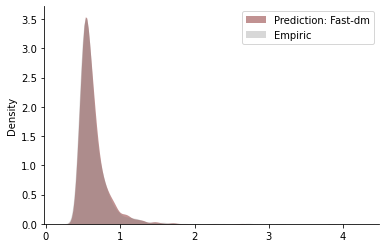

In [22]:
sns.kdeplot(np.abs(pred_rt_fast_dm), fill= '#852626', color="#852626", alpha=0.5, linewidth=0, label="Prediction: Fast-dm")
sns.kdeplot(pred_rt_dynamic,fill="#598f70", color="#598f70", alpha=0.5, linewidth=0, label="Prediction: Dynamic")
sns.kdeplot(np.abs(person_data.rt.values), fill="gray", color="gray", linewidth=0, alpha=0.3, label="Empiric")
sns.despine()
plt.legend()

In [ ]:
pred_rt_fast_dm.min()

In [ ]:
data = {'rt_fast_dm': pred_rt_fast_dm,
        'rt_dynamic': pred_rt_dynamic,
        'rt_empiric': person_data.rt.values}

df = pd.DataFrame(data)

In [ ]:
df.to_csv('model_comp_rt_pred.csv',
          index=False,
          sep=';')

In [ ]:
pred_data = pd.DataFrame()